In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import eig
import matplotlib.pyplot as plt

pi = np.pi

# Método de Rayleigth-Ritz

![image](\img\esquematico.png)

In [2]:
# Definição dos parâmetros da viga
L = 1.5                             # Comprimento da viga [m]
L1 = 0.0                            # Dividir a viga em seções
L2 = L/3
L3 = 2*L/3
rho = 7700                          # Densidade do material [kg/m**3]
E = 2.1e11                          # Modulo de elasticidade [Pa]
A1 = pi * 0.03**2 / 4               # Área da seção 1 [m**2]
A2 = pi * 0.06**2 / 4               # Área da seção 2 [m**2]
A3 = pi * 0.03**2 / 4               # Área da seção 3 [m**2]
I1 = (pi/4)*(0.03/2)**4             # Momento da seção 1 [m**4] 
I2 = (pi/4)*(0.06/2)**4             # Momento da seção 2 [m**4]
I3 = (pi/4)*(0.03/2)**4             # Momento da seção 3 [m**4]
m_eng = 20                          # Massa da engrenagem [kg]
J_eng = 0.25 * m_eng * 0.1**2       # Momento de inercia de massa da engreagem [kg*m**2]
k_mola = 2*10e3                     # Rigidez esquivalente das molas em paralelo [N/m]

# Matriz de massa pontual e momento de inércia de massa
MJ = np.zeros((4,4))
MJ[2,2] = m_eng
MJ[3,3] = J_eng

# Matriz de rigidez pontual
Keq = np.zeros((4,4))
Keq[2,2] = k_mola

def M_e(rho, A, a):
    return rho*A*a/105*np.array([[78, 22*a, 27, -13*a], [22*a, 8*a**2, 13*a, -6*a**2], [27, 13*a, 78, -22*a], [-13*a, -6*a**2, -22*a, 8*a**2]])

def K_e(E, I, a):
    return E*I/(2*a**3)*np.array([[3, 3*a, -3, 3*a], [3*a, 4*a**2, -3*a, 2*a**2], [-3, -3*a, 3, -3*a], [3*a, 2*a**2, -3*a, 4*a**2]])

## Determinando as matrizes de massa e rigidez

In [3]:
n = np.array([9, 18, 72])                  # Array com os numeros de elementos
resultados = dict()

for N in n:
    L_el = L/N                             # comprimento do elemento [m]
    a = L_el/2
    nodes = N + 1                          # Número de nós
    coord = np.linspace(0, L, N)           # coordenadas dos nós
    Ngl = 2*nodes                          # Número de graus de liberdade, dois por nó
    
    K = np.zeros((Ngl, Ngl))               # Pre-alocando matriz de rigidez
    M = np.zeros((Ngl, Ngl))               # Pre-alocando matriz de massa

    # Montando as matrizes de massa e rigidez
    for j in range(1, N+1):
        pos = j*L_el

        if pos>L1 and pos<=L2:  # primeiro trecho da viga
            Mee = np.zeros((Ngl,Ngl))            
            if pos==L2: # Contabiliza inércia da engrenagem
                Mee[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] = M_e(rho, A1, a) + MJ
            else:
                Mee[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] = M_e(rho, A1, a)
            M = M + Mee
            Kee = np.zeros((Ngl,Ngl))
            Kee[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] = K_e(E, I1, a)
            K = K + Kee
        elif pos>L2 and pos<=L3: # segundo trecho da viga
            Mee = np.zeros((Ngl,Ngl))
            Mee[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] = M_e(rho, A2, a)
            M = M + Mee
            Kee = np.zeros((Ngl,Ngl))
            if pos==L3:
                Kee[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] = K_e(E, I2, a) + Keq
            else:
                Kee[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] = K_e(E, I2, a)
            K = K + Kee
        elif pos>L3:             # terceiro trecho da viga
            Mee = np.zeros((Ngl,Ngl))
            Mee[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] = M_e(rho, A3, a)
            M = M + Mee
            Kee = np.zeros((Ngl,Ngl))
            Kee[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] = K_e(E, I3, a)
            K = K + Kee
    
    # Aplicando as condicoes de contorno geometricas
    cc = [1, 2] # Graus de Liberdade que devem ser restritos em ordem crescente.
    for j in range(1, len(cc)+1):
        M = np.delete(M, cc[j-1]-j, axis=1)
        M = np.delete(M, cc[j-1]-j, axis=0)
        K = np.delete(K, cc[j-1]-j, axis=1)
        K = np.delete(K, cc[j-1]-j, axis=0)

    # Problema de autovalor generalizado. W é um vetor e A uma matrix com as colunas normalizadas
    W, Vc = eig(K, M)

    # Ordenando os autovalores e a matriz de autovetores
    idx = W.argsort()
    W = W[idx]
    Vc = Vc[:,idx]

    # Normalizando os autovetores pela matriz de massa, de forma que A'@M@A = I
    m_r = np.diagonal(Vc.T @ M @ Vc)
    m_r = np.reciprocal(np.sqrt(m_r))
    for a in range(Vc.shape[1]):
        Vc[:,a] *= m_r[a] # multiplica cada coluna pelo fator de escala
       
    ## Montando as formas modais
    # Incluindo os GL das condições de contorno
    for c in cc:
        Vc = np.insert(Vc, c-1, 0, axis=0)

    resultados[N] = dict()
    resultados[N]['fn'] = (W**0.5/(2*pi)).real
    resultados[N]['x'] = np.arange(0, L+L_el, L_el)
    resultados[N]['V'] = Vc[0::2, :] # Modos de deslocamento (Gl 1,3,5,...) 
    resultados[N]['theta'] = Vc[1::2, :] # Modos angulares (Gl 2,4,6,...)
    resultados[N]['M'] = M
    resultados[N]['K'] = K

    # Faz as formas modais terem a mesma orientação
    for j in range(1, W.size):
        if np.sum(resultados[N]['V'][:,j-1]) >= 0:
            pass
        else:
            resultados[N]['V'][:,j-1] *= -1


# Frequências Naturais

In [4]:
pd.options.display.float_format = "{:.4f}".format
pd.DataFrame(data=[resultados[n_b]['fn'] for n_b in n], index=[f"n={i}" for i in n], columns=[f"f_{j}" for j in range(1, len(resultados[n.max()]['fn'])+1)])

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_135,f_136,f_137,f_138,f_139,f_140,f_141,f_142,f_143,f_144
n=9,9.6747,44.2620,124.2193,441.0274,570.9307,725.6321,1257.9897,1587.2426,1735.3782,2943.2002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n=18,9.6747,44.2616,124.2051,440.3731,568.9354,723.7565,1249.6293,1560.4460,1723.6753,2767.0330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n=72,9.6747,44.2615,124.2041,440.3245,568.7928,723.6046,1248.8527,1557.4280,1721.0674,2756.6233,...,939146.7501,1004936.1518,1072562.3444,1140802.2224,1207903.8146,1271540.6434,1328885.0388,1376879.4318,1412752.9046,1434664.7855


## Comparação das frequências naturais

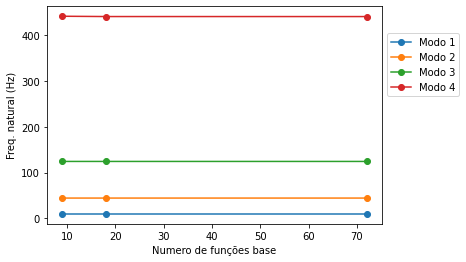

In [5]:
fn_N=np.zeros((4, len(n)))
for j in range(0,4): # numero de modos
    for k in range(len(n)): # Número de simulações
        fn_N[j, k] = resultados[n[k]]['fn'][j]
        
for j in range(fn_N[:,0].size):
    plt.plot(n, fn_N[j,:], marker='o')

plt.xlabel('Numero de funções base')
plt.ylabel('Freq. natural (Hz)')
plt.legend(['Modo 1', 'Modo 2','Modo 3', 'Modo 4'], loc='upper left', bbox_to_anchor=(1, 0.9))
plt.show()

# Formas Modais

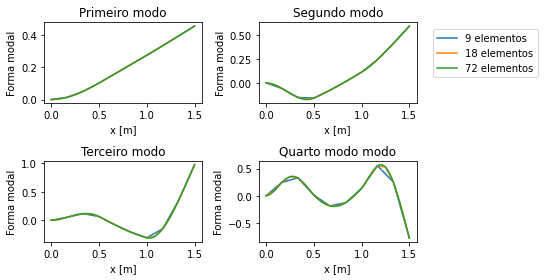

In [6]:
fig, axs = plt.subplots(2,2)

for n_b in n:
    x = np.linspace(0, L, len(resultados[n_b]['V'][:,0]))

    axs[0,0].set_title('Primeiro modo')
    axs[0,0].plot(x, resultados[n_b]['V'][:,0], label=f"{n_b} elementos")
    axs[0,0].set_xlabel('x [m]')
    axs[0,0].set_ylabel('Forma modal')
    
    axs[0,1].set_title('Segundo modo')
    axs[0,1].plot(x, resultados[n_b]['V'][:,1])
    axs[0,1].set_xlabel('x [m]')
    axs[0,1].set_ylabel('Forma modal')

    axs[1,0].set_title('Terceiro modo')
    axs[1,0].plot(x, resultados[n_b]['V'][:,2])
    axs[1,0].set_xlabel('x [m]')
    axs[1,0].set_ylabel('Forma modal')

    axs[1,1].set_title('Quarto modo modo')
    axs[1,1].plot(x, resultados[n_b]['V'][:,3])
    axs[1,1].set_xlabel('x [m]')
    axs[1,1].set_ylabel('Forma modal')


fig.legend(loc='upper left', bbox_to_anchor=(1, 0.9))
fig.tight_layout()
plt.show()